# Ford GoBike System Data
### by `Hamid Khodabandehloo`

## Table of Contents
<ul>
<li><a href="#Wrangling">Data Wrangling</a></li>
<li><a href="#questions">Research questions</a></li>
<li><a href="#Univariate">Univariate Exploration</a></li>
<li><a href="#Bivariate">Bivariate Exploration</a></li>
<li><a href="#Multivariate">Multivariate Exploration</a></li>
</ul>

<a id='Wrangling'></a>
## Preliminary Wrangling

> The data includs informations about station and trips of a bike sharing application (primarily, it was in 12 `csv` files with 15 columns and about 250k rows overal). In the `Wrangling.py` file I merged the files and fixed five quality and one tidiness issues. The wrangling process resulted in seperating the data into two tables and removing of about four percent of the data. The trip data includes start station id, end station id, start time, end time, duration and bike id. Stations data includes name, longitude and latitude of the bike-sharing stations.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# conda install -c conda-forge gmaps
import gmaps
import networkx as nx
# conda install -c conda-forge pyproj
import pyproj as Proj
import math
from Wrangling import downloadFile , downloadAllFiles, mergeAllFiles, clean, haversine
%matplotlib inline

### Data Wrangling
> Data gathering and cleaning is done in `Wrangling.py` and called in following cell. The clean data is stored in two csv files (`Stations.csv` and `Trips.csv`). The clean files are in the home directory of the project and you do not need to execute the cell every time.

In [3]:
#Download 12 files for each month of 2019 and unzip them
downloadAllFiles()

#Merge all 12 files in All.csv file and remove the rest
mergeAllFiles()

# Clean 5 quality issues and one tidiness issue
clean()

<a id='questions'></a>
### Research questions
> Clean data is imported in this section. Our main motivation is to understand people's bike riding behaviours such as when, where and why they use the bikes. These are the main question we are trying to answer in this project:
1. Which days in a week people use bikes more often and for how long? 
2. How the stations are distributed gegraphically?
3. What time in a day people use the bikes?
4. How bike usage changes in different monthes?
5. How long is a tipical trip duration?
6. Is there any travel between cities? 
7. How different users (Subscribers or casual customers) use the bikes?
8. How number of travels change during time in each city?
9. Which stations are the busiest?

In [2]:
df_stations = pd.read_csv('stations.csv', index_col=0)
df_trips = pd.read_csv('trips.csv', index_col=0, low_memory=False)

C:\Users\hamid\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_stations.head()

,station_id,latitude,longitude,name
0,3,37.786375,-122.404904,Powell St BART Station (Market St at 4th St)
1,4,37.785881,-122.408915,Cyril Magnin St at Ellis St
2,5,37.783899,-122.408445,Powell St BART Station (Market St at 5th St)
3,6,37.804770,-122.403234,The Embarcadero at Sansome St
4,7,37.804562,-122.271738,Frank H Ogawa Plaza


In [4]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 458
Data columns (total 4 columns):
station_id    456 non-null int64
latitude      456 non-null float64
longitude     456 non-null float64
name          456 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 17.8+ KB


In [5]:
df_stations.describe()

,station_id,latitude,longitude
count,456.000000,456.000000,456.000000
mean,247.789474,37.721975,-122.056325
std,142.295327,0.422517,3.175100
min,3.000000,37.309014,-122.495241
25%,128.500000,37.740096,-122.411729
50%,245.500000,37.776382,-122.384696
75%,376.250000,37.803313,-122.253071
max,498.000000,45.510000,-73.570000


In [6]:
df_stations.shape

(456, 4)

In [7]:
df_trips.head()

,duration_sec,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,bike_share_for_all_trip
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229,196,4861,Subscriber,No
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4,134,5506,Subscriber,No
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245,157,2717,Customer,No
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85,53,4557,Customer,No
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16,28,2100,Customer,No


In [8]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2407190 entries, 0 to 2506660
Data columns (total 8 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           int64
end_station_id             int64
bike_id                    int64
user_type                  object
bike_share_for_all_trip    object
dtypes: int64(4), object(4)
memory usage: 165.3+ MB


In [9]:
df_trips.describe()

,duration_sec,start_station_id,end_station_id,bike_id
count,2.407190e+06,2.407190e+06,2.407190e+06,2.407190e+06
mean,8.040941e+02,1.462486e+02,1.424772e+02,9.290447e+03
std,1.899553e+03,1.221957e+02,1.213281e+02,5.046314e+04
min,6.000000e+01,3.000000e+00,3.000000e+00,4.000000e+00
25%,3.580000e+02,4.700000e+01,4.200000e+01,1.877000e+03
50%,5.690000e+02,1.040000e+02,1.010000e+02,3.727000e+03
75%,8.830000e+02,2.420000e+02,2.390000e+02,7.170000e+03
max,8.623000e+04,4.980000e+02,4.980000e+02,9.984300e+05


In [10]:
df_trips.shape

(2407190, 8)

### What is the structure of your dataset?

> Information about the stations are stored in `df_stations` which includes folowing columns:
><br> **station_id:** Id of the station.
><br> **latitude:** Latitude GPS coordinate.
><br> **longitude:** Longitude GPS coordinate.
><br> **name:** Name of the station.
><br> This table has **4 columns** and **456 rows**.
><br>
><br> Information about trips are stored in df_trips which includes folowing columns:
><br> **duration_sec:** Duration of the trip in seconds.
><br> **start_time:** Start time of the trip.
><br> **end_time:** End time of the trip.
><br> **start_station_id:** The station that trip started from.
><br> **end_station_id:** The station that trip ended in.
><br> **bike_id:** Id of the bike used for the trip.
><br> **user_type:** Type of the user (subscriber or customer – “Subscriber” = Member or “Customer” = Casual)                
> **bike_share_for_all_trip:** If the bike is used for all trip.
><br> This table has **8 columns** and **2407190 rows**.

> These two table can be joined based on `station_id`, `start_station_id` and `end_station_id` columns.



### What is/are the main feature(s) of interest in your dataset?

> It is important to see how people are using bike sharing system. How bike usage change during a day, week, month and year. Which stations are bussier and when. How long people tend to use a bike and how far they go with the bike. How subscibers and casual customers differ in bike usage.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Start and end time and duration of the trip. GPS cordinates (I will need to add UTM cordinates to calculate trip distance). User type and bike id. I will need to add day of the week to the dataset too.

In [11]:
# Add week day of start and end time of the trip to df_trips
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips['end_time'] = pd.to_datetime(df_trips['end_time'])
    
df_trips['start_weekday'] = df_trips['start_time'].dt.dayofweek
df_trips['end_weekday'] = df_trips['end_time'].dt.dayofweek


# Remove stations outside the region
df_stations = df_stations.query('latitude > 37.207932 and latitude < 37.881729 and longitude > -122.671773 and longitude < -121.698069')

# Add city to df_stations
df_stations['city'] = ''

df_stations.loc[(df_stations['latitude'] > 37.691495) & (df_stations['latitude'] < 37.825785) & (df_stations['longitude'] < -122.376299) &  (df_stations['longitude'] > -122.533738),['city']] = 'San Francisco'
df_stations.loc[(df_stations['latitude'] > 37.711895) & (df_stations['latitude'] < 37.899914) & (df_stations['longitude'] < -22.141754) &  (df_stations['longitude'] > -122.360498),['city']] = 'Oakland'
df_stations.loc[df_stations['city']=="",['city']] = 'San Jose'


# We are only intrested on trips shorter than 2 hours
df_trips = df_trips.query('duration_sec <= 2*3600')

# Join stations and trip data 
df = df_stations.merge(df_trips, how='inner',left_on='station_id', right_on='start_station_id' ).merge(df_stations, how='inner',left_on='end_station_id', right_on='station_id')

# Add distance and speed to df
df['distance'] = df.apply(lambda x: haversine((x['latitude_x'], x['longitude_x']),(x['latitude_y'], x['longitude_y'])), axis=1)
df['speed'] = df.apply(lambda x : round((x['distance']/1000) / (x['duration_sec']/3600),2), axis=1)

# Trips between cities
df_outOfCityTrips = df[df['city_x'] != df['city_y']]

<a id='Univariate'></a>
## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

### Day of the week
#### Number of trips:
> Number of trips are considerably higher during the week comparing to the weekend. It can be an indication that people use bikes to commute to work.

#### Mean duration of trips:
> The mean duration of trips are about 3 minutes more at weekends.

#### Mean distance of trips:
> The mean distance of trips are slightly shorter during weekends.

#### Mean speed of trips:
> The mean speed of trips is about 1.5km/h less during weekends.

>As we can see in the following graphs, people's behaviour towards riding bikes is very different during weekdays and weekends. During weekdays people have more trips and ride faster. They go longer distances slightly in a shorter time. We can conclude that during weekdays people use bikes more seriously, probably for commuting between home and work. But at weekends it is more for pleasure.

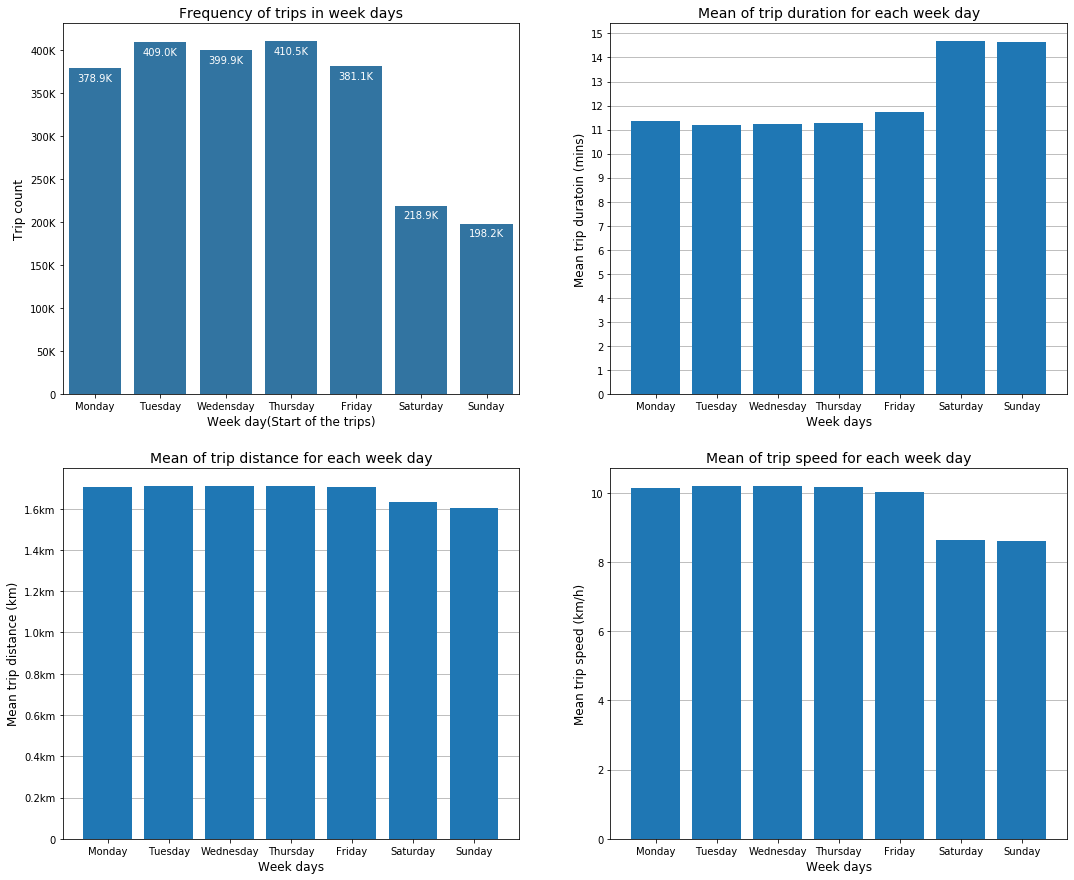

In [263]:
# Trip frequency during weekday and weekends

plt.figure(figsize=[18,15])

plt.subplot(2,2,1)
base_color = sb.color_palette()[0]
sb.countplot(data=df_trips, x = 'start_weekday', color=base_color);
plt.xlabel('Week day(Start of the trips)',fontsize=12)
plt.ylabel('Trip count',fontsize=12)
plt.title('Frequency of trips in week days',fontsize=14)
plt.yticks(np.arange(0, 450000, 50000), ['0', '50K', '100K','150K','200K','250K','300K','350K','400K']);
n_points=df_trips.shape[0]

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = len(df_trips[df_trips['start_weekday'] == int(label.get_text())])
    pct_string = '{:0.1f}K'.format(count/1000)
    plt.text(loc, count-15000, pct_string, ha='center', color='w' )
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wedensday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);



plt.subplot(2,2,2);
data = df_trips.groupby('start_weekday').mean()['duration_sec'].reset_index()
plt.bar(data=data, x = 'start_weekday', height='duration_sec')
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(np.arange(0,901,60),np.arange(0,16,1))
plt.title('Mean of trip duration for each week day', fontsize = 14)
plt.ylabel('Mean trip duratoin (mins)', fontsize = 12)
plt.xlabel('Week days', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

plt.subplot(2,2,3);
data = df.groupby('start_weekday').mean()['distance'].reset_index()
plt.bar(data=data, x = 'start_weekday', height='distance')
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(np.arange(0,1601,200),['0','0.2km','0.4km','0.6km','0.8km','1.0km','1.2km','1.4km','1.6km'])
plt.title('Mean of trip distance for each week day', fontsize = 14)
plt.ylabel('Mean trip distance (km)', fontsize = 12)
plt.xlabel('Week days', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

plt.subplot(2,2,4);
data = df.groupby('start_weekday').mean()['speed'].reset_index()
plt.bar(data=data, x = 'start_weekday', height='speed')
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#plt.yticks(np.arange(0,1601,200),['0','0.2km','0.4km','0.6km','0.8km','1.0km','1.2km','1.4km','1.6km'])
plt.title('Mean of trip speed for each week day', fontsize = 14)
plt.ylabel('Mean trip speed (km/h)', fontsize = 12)
plt.xlabel('Week days', fontsize = 12)
plt.grid(True, axis='y', which='both')
plt.rcParams['axes.axisbelow'] = True

### City Analysis:
#### Number of stations:
> There are more bike sharing stations in San Francisco comparing to Oakland and San Jose. San Francisco has 230 stations, Oakland 132 and San Jose 94. However, San Jose is the most populated city among these three cities but number of bike stations are less than other cities. To understand number of stations based on population see the following table:

| City | Population | Bike statation per 100,000 people |
| --- | --- | --- |
| San Jose | 1,035,000 | 9.37 |
| San Francisco| 884,000 | 26 |
| Oakland | 425,000 | 31 |


>Oakland has the most bike stations considering the population.


#### Mean of trip duration:
>Trips are generally longer in San Francisco. Trips in Oakland and San Jose takes about 10 minutes. This number in San Francisco is about 12 minutes.

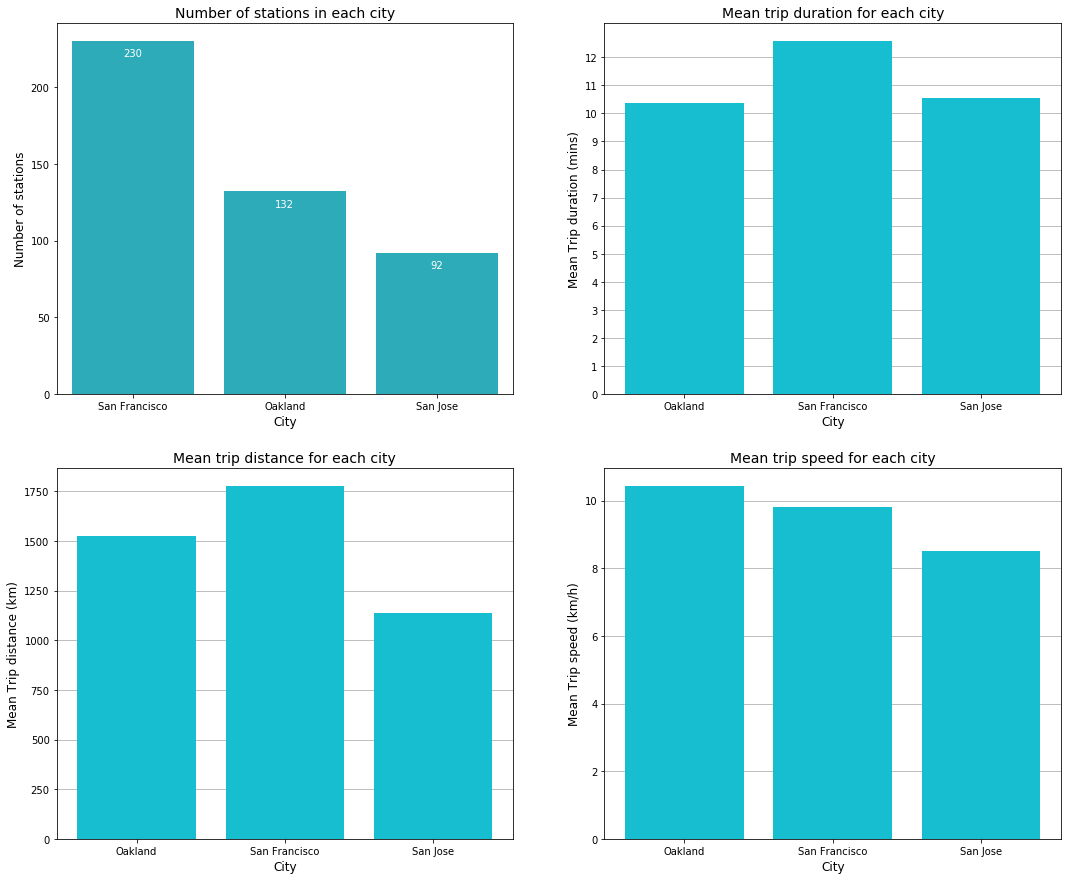

In [13]:
# City analysis
plt.figure(figsize=[18,15])

plt.subplot(2,2,1)
base_color = sb.color_palette()[9]
sb.countplot(data=df_stations, x = 'city', color=base_color);
plt.title('Number of stations in each city', fontsize = 14);
plt.ylabel('Number of stations',fontsize = 12);
plt.xlabel('City',fontsize = 12);

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = len(df_stations[df_stations['city'] == label.get_text()])
    plt.text(loc, count-10, count, ha='center', color='w' )

    
plt.subplot(2,2,2)
base_color = sb.color_palette()[9]
data = df.groupby('city_x').mean()['duration_sec'].reset_index()
plt.bar(data=data, x = 'city_x',height='duration_sec', color=base_color);
plt.title('Mean trip duration for each city', fontsize = 14)
plt.ylabel('Mean Trip duration (mins)',fontsize = 12);
plt.xlabel('City',fontsize = 12);
plt.yticks(np.arange(0,721,60), np.arange(0,13,1));
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(2,2,3)
base_color = sb.color_palette()[9]
data = df.groupby('city_x').mean()['distance'].reset_index()
plt.bar(data=data, x = 'city_x',height='distance', color=base_color);
plt.title('Mean trip distance for each city', fontsize = 14)
plt.ylabel('Mean Trip distance (km)',fontsize = 12);
plt.xlabel('City',fontsize = 12);
#plt.yticks(np.arange(0,721,60), np.arange(0,13,1));
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(2,2,4)
base_color = sb.color_palette()[9]
data = df.groupby('city_x').mean()['speed'].reset_index()
plt.bar(data=data, x = 'city_x',height='speed', color=base_color);
plt.title('Mean trip speed for each city', fontsize = 14)
plt.ylabel('Mean Trip speed (km/h)',fontsize = 12);
plt.xlabel('City',fontsize = 12);
#plt.yticks(np.arange(0,721,60), np.arange(0,13,1));
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


### Hour of the trip:
#### Number of trips:
> Between 7 to 9 am and 16 to 18 pm are pick time for bike usage. These hours are the times when usually people commute. This is another indication that people are using bikes for commuting between home and work. 
#### Mean of trip durations:
> Trip duration mean is almost the same in different hours of a day.

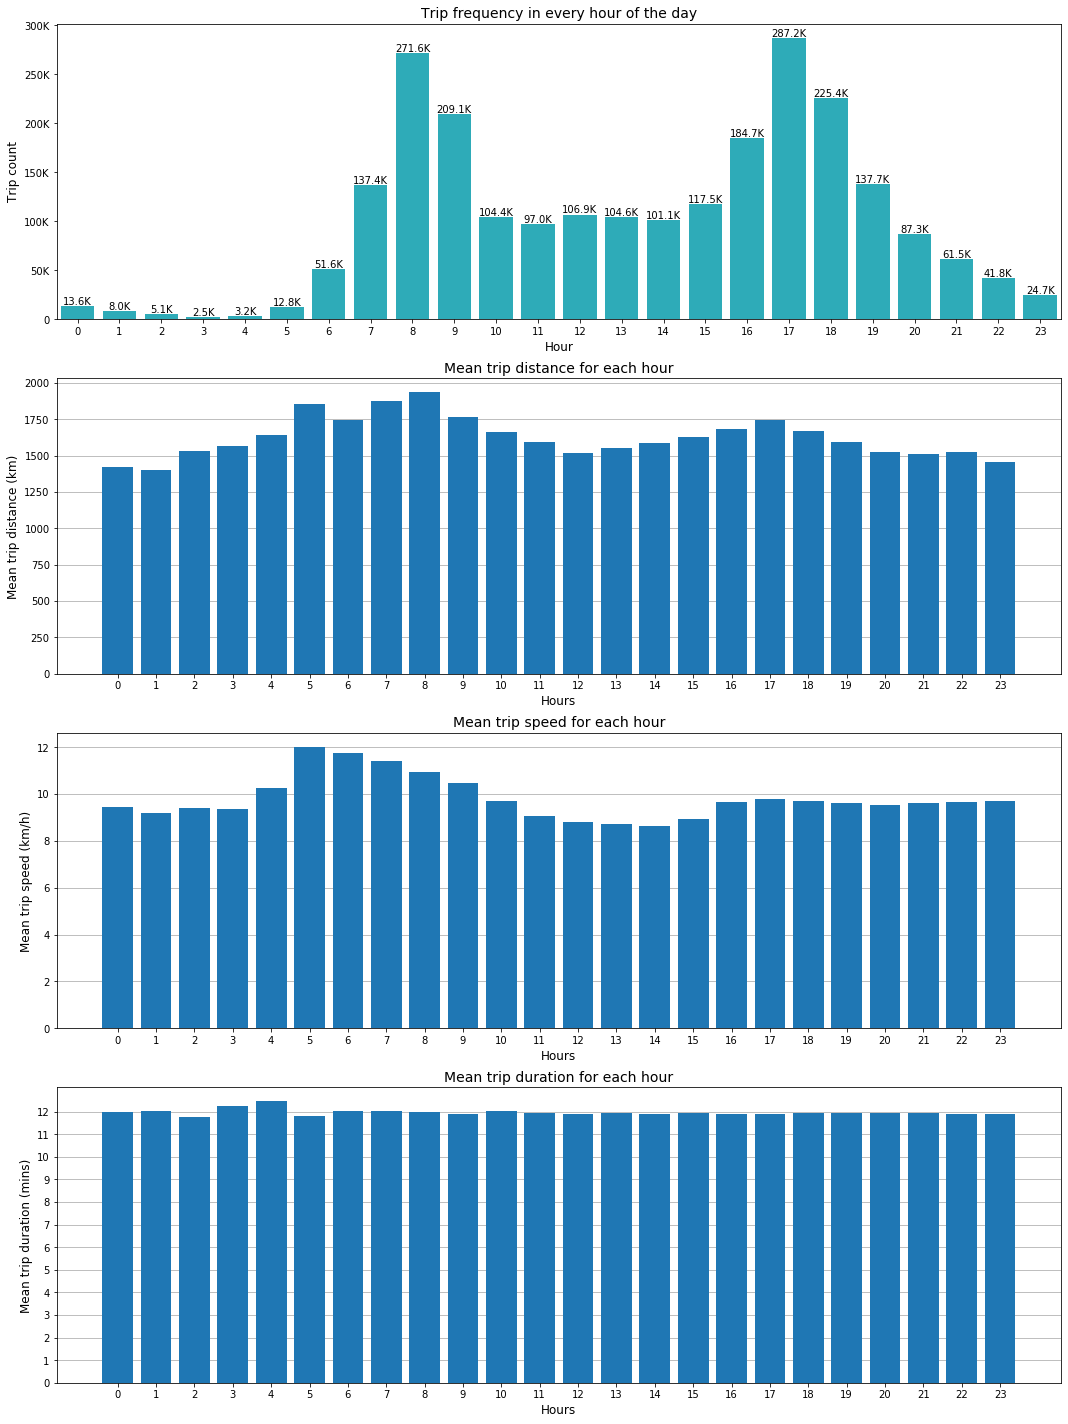

In [14]:

plt.figure(figsize=[18,25])


plt.subplot(4,1,1)
base_color = sb.color_palette()[9]
data = df_trips['start_time'].dt.hour.reset_index()
sb.countplot(data=data, x='start_time', color=base_color);
plt.title('Trip frequency in every hour of the day', fontsize = 14)
plt.xlabel('Hour', fontsize=12);
plt.ylabel('Trip count', fontsize=12);
locs, lables = plt.xticks()
for loc,label in zip(locs, lables):
    count = len(data[data['start_time'] == int(label.get_text())])
    plt.text(loc, count+1500,str(round(count/1000,1)) +'K', ha='center', color='black')
plt.yticks(np.arange(0,300001, 50000), ['0','50K','100K','150K','200K','250K','300K']);

plt.subplot(4,1,4);
data = df_trips.groupby(df['start_time'].dt.hour).mean()['duration_sec'].reset_index()
plt.bar(data=data, x = 'start_time', height='duration_sec')
plt.xticks(np.arange(0,24,1));
plt.yticks(np.arange(0,750,60), np.arange(0,13,1));
plt.title('Mean trip duration for each hour', fontsize = 14)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Mean trip duration (mins)', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(4,1,2);
data = df.groupby(df['start_time'].dt.hour).mean()['distance'].reset_index()
plt.bar(data=data, x = 'start_time', height='distance')
plt.xticks(np.arange(0,24,1));
#plt.yticks(np.arange(0,750,60), np.arange(0,13,1));
plt.title('Mean trip distance for each hour', fontsize = 14)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Mean trip distance (km)', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(4,1,3);
data = df.groupby(df['start_time'].dt.hour).mean()['speed'].reset_index()
plt.bar(data=data, x = 'start_time', height='speed')
plt.xticks(np.arange(0,24,1));
#plt.yticks(np.arange(0,750,60), np.arange(0,13,1));
plt.title('Mean trip speed for each hour', fontsize = 14)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Mean trip speed (km/h)', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

### Month Analysis:

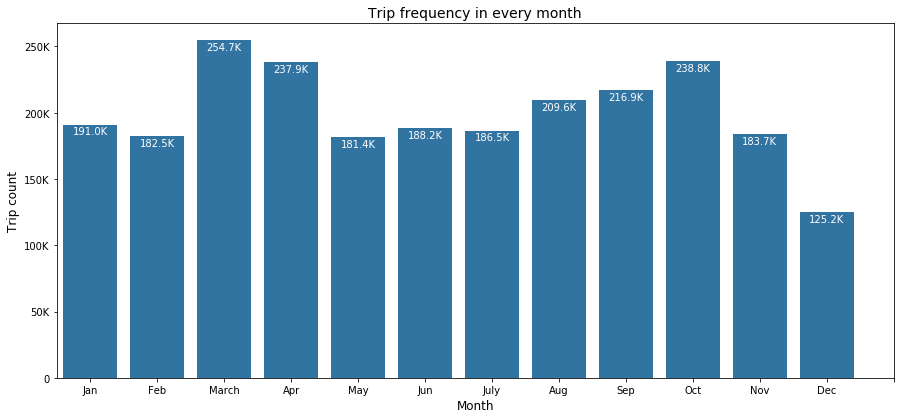

In [15]:
plt.figure(figsize = [15,30]);

plt.subplot(4,1,1)
base_color = sb.color_palette()[0]
data = df_trips['start_time'].dt.month.reset_index()
plt.title('Trip frequency in every month', fontsize = 14)
sb.countplot(data=data, x='start_time', color=base_color);
locs, lables = plt.xticks()
for loc,label in zip(locs, lables):
    count = len(data[data['start_time'] == int(label.get_text())])
    plt.text(loc, count-7500,str(round(count/1000,1)) +'K', ha='center', color='w' )   
plt.xticks(np.arange(0,13,1),['Jan','Feb','March','Apr','May','Jun','July','Aug','Sep','Oct','Nov', 'Dec']);
plt.yticks(np.arange(0,300000, 50000), ['0','50K','100K','150K','200K','250K']);
plt.xlabel('Month', fontsize=12);
plt.ylabel('Trip count', fontsize=12);

### Trip duration analysis:
> Folowing histograms show

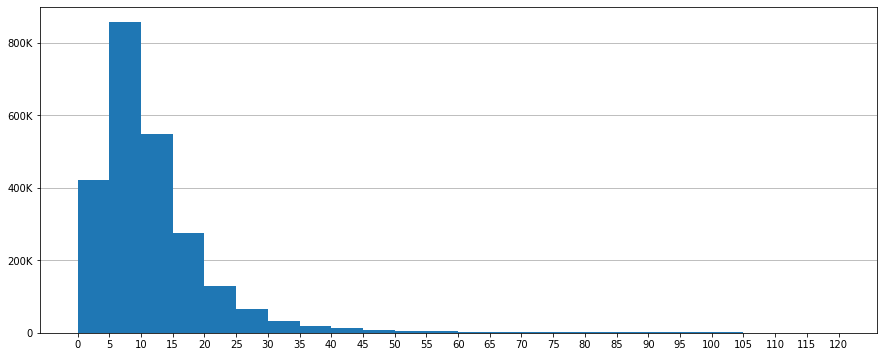

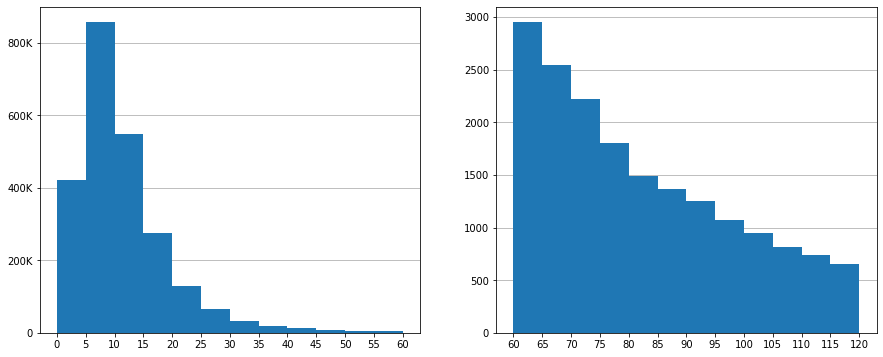

In [16]:
# Trip duration histogram
plt.figure(figsize=[15,6])
bins= np.arange(0, 2*3600+1, 300)
plt.hist(data=df_trips, x='duration_sec', bins=bins);
plt.xticks(np.arange(0, 2*3600+1, 300),np.arange(0, 121, 5));
plt.yticks(np.arange(0, 900001, 200000),['0','200K','400K','600K','800K']);
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

# Trip duration histogram for less than an hour and between one and two hours
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
data = df_trips.query('duration_sec <= 3600')
bins= np.arange(0, 3600+1, 300)
plt.hist(data=data, x='duration_sec', bins=bins);
plt.xticks(np.arange(0, 3601, 300),np.arange(0, 61, 5));
plt.yticks(np.arange(0, 900001, 200000),['0','200K','400K','600K','800K'])
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

plt.subplot(1,2,2)
data = df_trips.query('duration_sec > 3600')
bins= np.arange(3600, 2*3600+1, 300)
plt.hist(data=data, x='duration_sec', bins=bins);
plt.xticks(np.arange(3600, 2*3600+1, 300),np.arange(60, 121, 5));
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

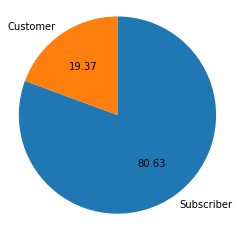

In [17]:
data = df_trips.user_type.value_counts()
plt.pie(data, labels = data.index, startangle=90, counterclock=False, autopct='%.2f');
plt.axis('square');

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

<a id='Bivariate'></a>
## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [18]:
with open('auth', 'r') as file:
    key = file.read().replace('\n', '')
gmaps.configure(api_key=key)

In [19]:
#markers = gmaps.marker_layer(df_stations[['start_station_latitude','start_station_longitude']])
markers = gmaps.symbol_layer(df_stations[['latitude','longitude']], fill_color='blue', stroke_color='blue',scale=1,fill_opacity=0.2 )
fig = gmaps.figure(center=(37.60158, -122.233234), zoom_level=10, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [20]:
#San Francisco
locations = df_stations.query('city=="San Francisco"')[['latitude','longitude','station_id','name']].reset_index()
locations['text'] ='Station Id: ' +locations['station_id'].apply(str)+' - Name: '+ locations['name']
markers = gmaps.marker_layer(locations[['latitude','longitude']], info_box_content = locations['text'])
fig = gmaps.figure(center=(37.77498, -122.419234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [21]:
#Oakland
locations = df_stations.query('city == "Oakland"')[['latitude','longitude','station_id','name']].reset_index()
locations['text'] ='Station Id: ' +locations['station_id'].apply(str)+' - Name: '+ locations['name']
markers = gmaps.marker_layer(locations[['latitude','longitude']], info_box_content = locations['text'])
fig = gmaps.figure(center=(37.82448, -122.271234), zoom_level=12.5, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [22]:
# San Jose
locations = df_stations.query('city == "San Jose"')[['latitude','longitude','station_id','name']].reset_index()
locations['text'] ='Station Id: ' +locations['station_id'].apply(str)+' - Name: '+ locations['name']
markers = gmaps.marker_layer(locations[['latitude','longitude']], info_box_content = locations['text'])
fig = gmaps.figure(center=(37.34058, -121.890234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

In [295]:
data = df_trips[['start_time','user_type']]
data.loc[:,'hour'] = 0
data.loc[:,'hour'] = data['start_time'].dt.hour
data = data.pivot_table(index='hour', columns='user_type',aggfunc='count')
data['rate'] = round(data[('start_time',   'Customer')]/data[('start_time',   'Subscriber')] * 100 , 2)
data['rate(5000x)'] = data['rate']*5000
data['rate'] = data['rate'].apply(lambda x: '{0:.2f}%'.format(x))
data = data.reset_index()
data.columns = ['hour','Customer','Subscriber','rate', 'rate(5000x)']

C:\Users\hamid\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hamid\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


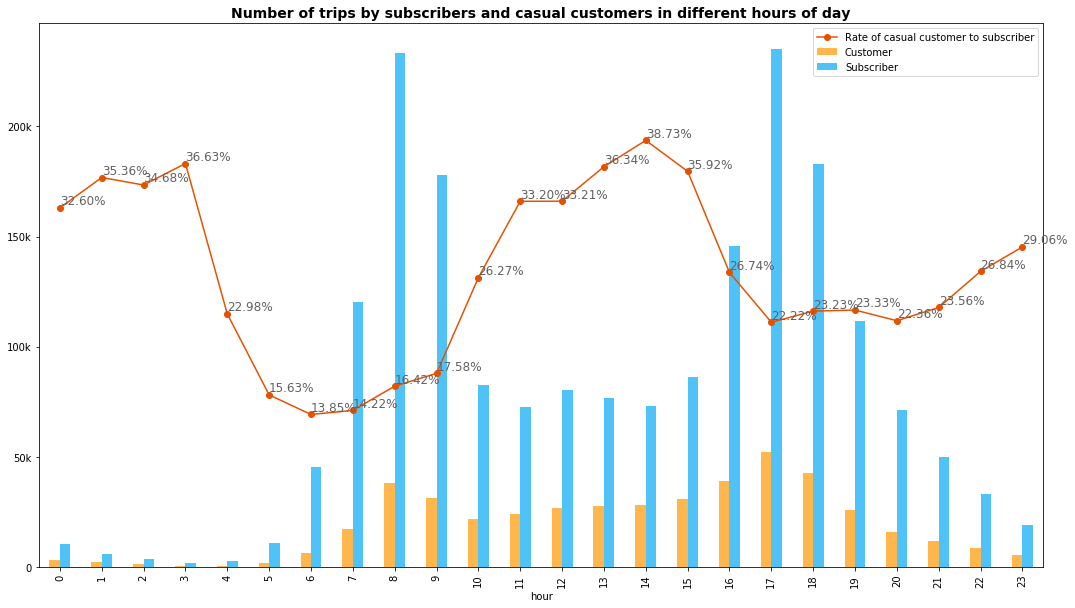

In [296]:
fig1, ax = plt.subplots(figsize=[18,10])
data['rate(5000x)'].plot(linestyle='-', marker='o', color = '#E65100')
data[['hour','Customer','Subscriber']].plot(x='hour', kind='bar', ax =ax, color=['#FFB74D','#4FC3F7'])
plt.title("Number of trips by subscribers and casual customers in different hours of day", fontsize = 14, fontweight='bold')
plt.legend(['Rate of casual customer to subscriber','Customer','Subscriber'])
plt.yticks(np.arange(0,200001,50000), ['0','50k','100k','150k','200k'])


x = ax.get_xticks()
for a,b,c in zip(x,data['rate(5000x)'], np.array( data['rate'])):
    plt.text(a,b+1500,c, color='#616161', fontsize=12)

In [297]:
data = df_trips[['start_time','user_type','start_weekday']]
data = data.pivot_table(index='start_weekday', columns='user_type',aggfunc='count')
data['rate'] = round(data[('start_time',   'Customer')]/data[('start_time',   'Subscriber')] * 100 , 2)
data['rate(5000x)'] = data['rate']*5000
data['rate'] = data['rate'].apply(lambda x: '{0:.2f}%'.format(x))
data = data.reset_index()
data.columns = ['hour','Customer','Subscriber','rate', 'rate(5000x)']

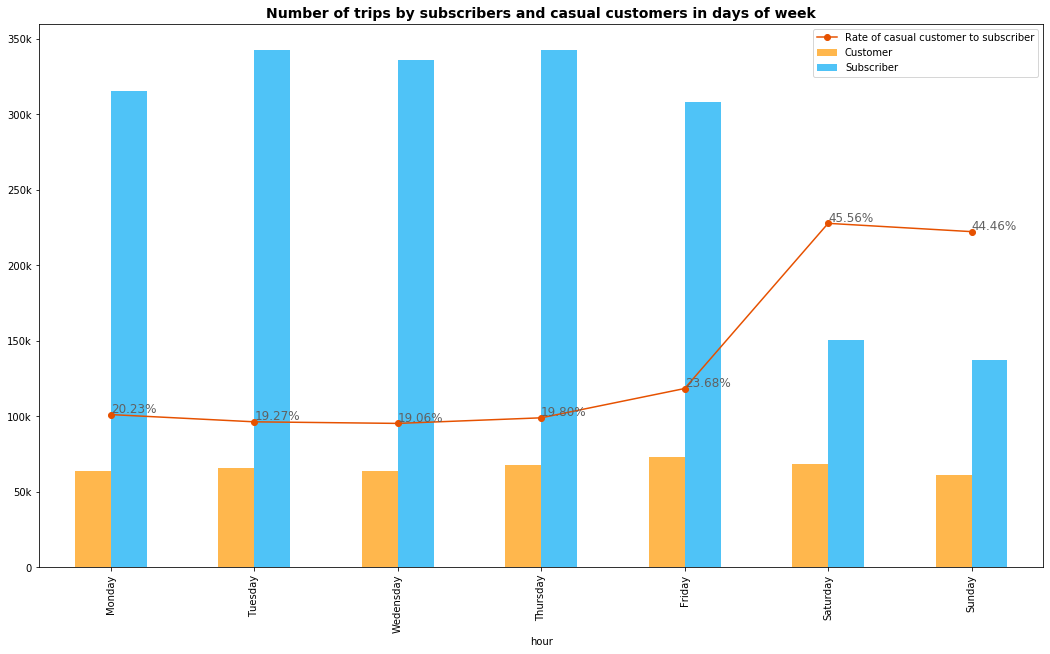

In [298]:
fig1, ax = plt.subplots(figsize=[18,10])
data['rate(5000x)'].plot(linestyle='-', marker='o', color = '#E65100')
data[['hour','Customer','Subscriber']].plot(x='hour', kind='bar', ax =ax, color=['#FFB74D','#4FC3F7'])
plt.title("Number of trips by subscribers and casual customers in days of week", fontsize = 14, fontweight='bold')
plt.legend(['Rate of casual customer to subscriber','Customer','Subscriber'])
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wedensday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.yticks(np.arange(0,350001,50000), ['0','50k','100k','150k','200k','250k','300k','350k'])

x = ax.get_xticks()
for a,b,c in zip(x,data['rate(5000x)'], np.array( data['rate'])):
    plt.text(a,b+1500,c, color='#616161', fontsize=12)

In [299]:
data = df[['start_time','user_type','city_x']]
data = data.pivot_table(index='city_x', columns='user_type',aggfunc='count')
data['rate'] = round(data[('start_time',   'Customer')]/data[('start_time',   'Subscriber')] * 100 , 2)
data['rate(20000x)'] = data['rate']*20000
data['rate'] = data['rate'].apply(lambda x: '{0:.2f}%'.format(x))
data = data.reset_index()
data.columns = ['hour','Customer','Subscriber','rate', 'rate(20000x)']

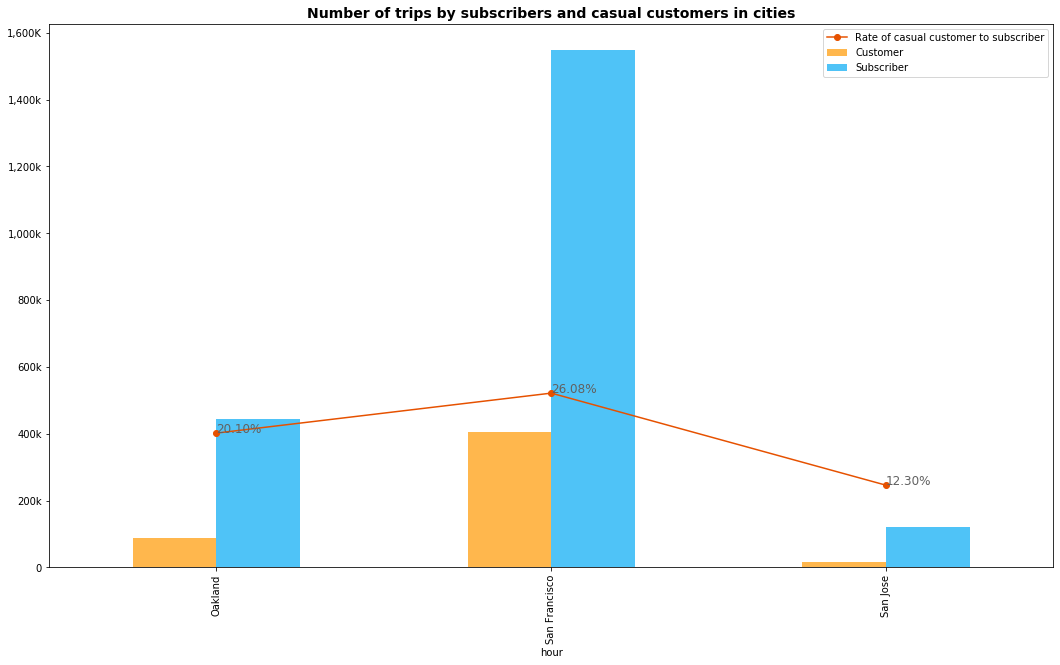

In [300]:
fig1, ax = plt.subplots(figsize=[18,10])
data['rate(20000x)'].plot(linestyle='-', marker='o', color = '#E65100')
data[['hour','Customer','Subscriber']].plot(x='hour', kind='bar', ax =ax, color=['#FFB74D','#4FC3F7'])
plt.title("Number of trips by subscribers and casual customers in cities", fontsize = 14, fontweight='bold')
plt.legend(['Rate of casual customer to subscriber','Customer','Subscriber'])
plt.yticks(np.arange(0,1600001,200000), ['0','200k','400k','600k','800k','1,000k','1,200k','1,400k','1,600K'])

x = ax.get_xticks()
for a,b,c in zip(x,data['rate(20000x)'], np.array( data['rate'])):
    plt.text(a,b+1500,c, color='#616161', fontsize=12)

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

<a id='Multivariate'></a>
## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

<Figure size 1080x1080 with 0 Axes>

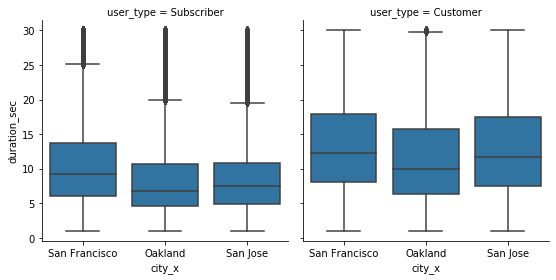

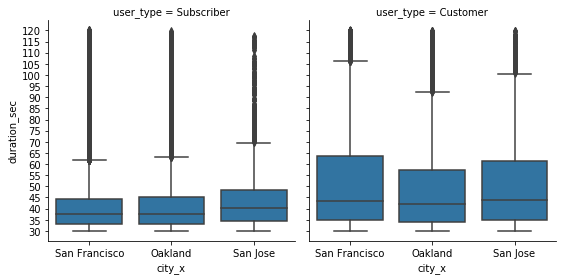

In [301]:
plt.figure(figsize=[15,15])

data = df.query('duration_sec <= 1800')
g = sb.FacetGrid(data = data, col ='user_type', height = 4)
g.map(sb.boxplot,'city_x', 'duration_sec',order=["San Francisco","Oakland","San Jose"] );
plt.yticks(np.arange(0,1801,300), np.arange(0,31,5));

data = df.query('duration_sec > 1800')
g = sb.FacetGrid(data = data, col ='user_type', height = 4)
g.map(sb.boxplot,'city_x', 'duration_sec',order=["San Francisco","Oakland","San Jose"] );
plt.yticks(np.arange(1800,2*3600+1,300), np.arange(30,121,5));

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!